In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


In [2]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')

In [60]:
# xservs_catalog.columns[109]
# str(xservs_catalog['CLASS'][10])[1]
xservs_catalog['ZPHOT', 'ZPHOT_UERR', 'ZPHOT_LERR']

ZPHOT,ZPHOT_UERR,ZPHOT_LERR
float64,float64,float64
-99.0,-99.0,-99.0
-99.0,-99.0,-99.0
0.431,0.485,0.217
-99.0,-99.0,-99.0
-99.0,-99.0,-99.0
-99.0,-99.0,-99.0
1.4,1.6840000000000002,1.047
1.815,1.995,1.449
0.308,0.37799999999999995,0.16899999999999998


(0.19979091949637545, 0.12801449828309808)

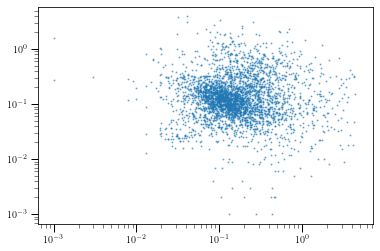

In [75]:
fig, axs = plt.subplots()
plt.plot(xservs_catalog['ZPHOT_UERR']-xservs_catalog['ZPHOT'], xservs_catalog['ZPHOT'] - xservs_catalog['ZPHOT_LERR'], marker='o', ms=1, ls='', alpha=0.5)
axs.set_xscale('log')
axs.set_yscale('log')
np.mean(xservs_catalog['ZPHOT_UERR']-xservs_catalog['ZPHOT']), np.mean(xservs_catalog['ZPHOT'] - xservs_catalog['ZPHOT_LERR'])

In [4]:
lum_selected_agn = [str(selection)[1] == '2' for selection in xservs_catalog['CLASS']]
print(np.sum(lum_selected_agn))

1625


In [5]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e45

z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in xservs_catalog])
l = xservs_catalog['LX'].data

good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
l = xservs_catalog['LX'][good_redshift_and_l_selected].data
z = z[good_redshift_and_l_selected]
# print(z)

[0.48861861 0.61877899 0.78361206 0.9923541  1.25670175 1.5914675
 2.01540963 2.55228333 3.2321718  4.09317197]
1421


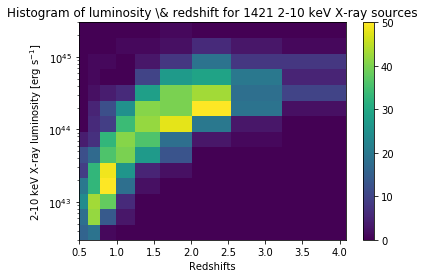

In [6]:
num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min)-0.01, np.log10(z_sample_max)+0.01, num=num_bins_z)
print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

print(len(z))
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='2-10 keV X-ray', unit=r'erg s$^{-1}$')

In [7]:
cosmo = af.setup_cosmology()

flux_limit = 6.5e-15
zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.01)
zmin = np.array([0]*len(zmax))

full_fluxes = xservs_catalog['FB_FLUX']
coverage_correction = vmax.coverage_correction(full_fluxes, full_fluxes[good_redshift_and_l_selected])

import astropy.units as u
def cov_func(l, z):
    
    flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
    return 8 * coverage_correction(flux)

vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=cov_func)

[6 3 6 ... 7 1 6]


In [8]:
1/vmax_vals[:10]**2

array([[1.47519444e-100],
       [8.56833162e-099],
       [1.66726957e-102],
       [1.82036762e-098],
       [4.75617504e-102],
       [2.38423358e-094],
       [7.71334080e-097],
       [9.03248361e-101],
       [1.77757215e-097],
       [3.29767972e-103]])

In [9]:
import importlib
importlib.reload(vmax)
l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

In [10]:
zero_bin = np.array([(0,0)]*num_bins_l)
ranalli75 = np.array([[1.8204781835615654e+42, 0.00004688702004672812],
[5.768251354223323e+42, 0.00012551169959105474],
[1.8224728420637193e+43, 0.0000808899816399594],
[5.67651928907583e+43, 0.00004281332398719396],
[1.7906555296923534e+44, 0.000012551169959105474],
[5.640716651800656e+44, 0.0000018329807108324375],
[1.7787122083815078e+45, 4.4803896929336637e-7],
[5.601901226975743e+45, 5.884869574824701e-8]])
ranalli125 = np.array([[5.5435860594493034e+42, 0.000011753985687895042],
[1.7223596240621015e+43, 0.00005627622162420234],
[5.448405638807658e+43, 0.00004791131283650859],
[1.7259405451530703e+44, 0.000020766691479308065],
[5.556837965273878e+44, 0.000003736408486470932],
[1.7386035802007045e+45, 6.215740165584362e-7],
[5.609887898604562e+45, 3.906235874255027e-8
]])
ranalli175 = np.array([[1.7879934792230063e+43, 0.000015551805709238664],
[5.716073332551424e+43, 0.00004473886184925997],
[1.801028165980116e+44, 0.000026170270956732876],
[5.7577441922252836e+44, 0.000008146271948214161],
[1.787993479222977e+45, 8.146271948214161e-7]])
ranalli250 = np.array([[5.424154918951895e+43, 0.00001601379932965642],
[1.7134066660943036e+44, 0.00002714612628809034],
[5.432130267357807e+44, 0.00000784119081413017],
[1.725103245577943e+45, 9.948390153580107e-7
]])
ranalli350 = np.array([[5.516216936863732e+43, 0.0000073015881038410896],
[1.7627901206921975e+44, 0.000009293287013925729],
[5.793192144773722e+44, 0.000004437724247661295],
[1.7751707021476756e+45, 2.9840845599069994e-7
]])
lit_data={'Ranalli 2016':[ranalli75, ranalli75, ranalli75, ranalli125, ranalli125, ranalli175, ranalli250, ranalli250, ranalli350]}

In [11]:
aird5 = np.array([[2.033624084686662e+41, 0.0004650924258972792],
[4.832930238571732e+41, 0.0003181396515358571],
[1.1485512424239157e+42, 0.00020988892770326998],
[2.7772119324293323e+42, 0.0001849335501313507],
[6.600075022827048e+42, 0.00006137028147523471],
[1.541593692842248e+43, 0.00003976275248399674],
[3.6636145440206636e+43, 0.00002353573408996959],
[8.85866790410065e+43, 0.000004969756135303314],
[2.105272272765668e+44, 0.0000019059201959126445],
[5.003202953825917e+44, 2.297505419511507e-7],
[1.1686088553466402e+45, 1.1556523988776559e-7
]])
aird6 = np.array([[2.0549813357409736e+41, 0.0016076280197404778],
[4.893900918477419e+41, 0.001106151042531592],
[1.1074776624451061e+42, 0.00042294964015028575],
[2.775554463314989e+42, 0.00030698234695950466],
[6.498421570076656e+42, 0.0001864741158671012],
[6.498421570076656e+42, 0.0001864741158671012],
[1.5475873545578656e+43, 0.00009823540528533097],
[3.685551320671243e+43, 0.00004105840382532986],
[8.777073873921625e+43, 0.0000062203444311790165],
[2.126112333899638e+44, 0.000005491496632886971],
[4.8939009184774186e+44, 9.593095388678326e-7],
[1.165473660676274e+45, 8.672500426996944e-8
]])
aird8 = np.array([[1.1783152148394137e+42, 0.0009369253689310116],
[2.7746838332769845e+42, 0.00029650531783107816],
[6.772285498714152e+42, 0.00022696133040863876],
[1.5446158257255e+43, 0.00014821522821837686],
[3.70382905944931e+43, 0.00007968548021212688],
[9.022576566049425e+43, 0.000027544328386614646],
[2.12792484345009e+44, 0.000016465418994218013],
[5.008008140019909e+44, 0.000004141490330951619],
[1.1749183117831125e+45, 2.86841317712791e-7],
[2.8035271989546578e+45, 2.058037222352539e-8
]])
aird10 = np.array([[1.1333269171297019e+42, 0.00039810717055349936],
[2.6434551458924697e+42, 0.00033944485527694036],
[6.495226024243585e+42, 0.00017316556668620905],
[1.5410634236889313e+43, 0.0001400083205615401],
[3.538289498751096e+43, 0.00007399983804321452],
[8.542029874459734e+43, 0.00005011872336272735],
[2.0303886897216604e+44, 0.000019258186341850842],
[1.1318518701355524e+45, 6.772815277441427e-7],
[2.7444892780963372e+45, 7.666822074546222e-8
]])
aird12 = np.array([[2.6176431902199304e+42, 0.00021308508748061854],
[6.396908655341961e+42, 0.00008230683000823993],
[1.5632550875412025e+43, 0.00006904517189119679],
[3.8202303649946607e+43, 0.000056885012344750115],
[8.56713914996759e+43, 0.000028785865995513617],
[1.9884169780083154e+44, 0.00002015722986549392],
[4.943446640476108e+44, 0.0000015639566064715666],
[1.1672507969054455e+45, 0.0000013599094625740439],
[6.620572143707537e+45, 1.1527308442089969e-8
]])
aird15 = np.array([[6.599517656509027e+42, 0.000051561608146754346],
[1.5584143078691544e+43, 0.00003378064342984338],
[3.742576891418273e+43, 0.00003210455127221931],
[8.690092320062009e+43, 0.000028930160581617874],
[2.017799679797168e+44, 0.000011958412935968476],
[4.845804106769178e+44, 0.0000041410520965573],
[1.1251735441780527e+45, 0.0000012225863699109943],
[2.7021367065307643e+45, 5.329871001276772e-7],
[6.380842850117492e+45, 1.4402662261974964e-8
]])
aird20 = np.array([[3.6067207952730063e+43, 0.000030351385686916772],
[8.570349978994005e+43, 0.000013203131390722677],
[2.0324276585584765e+44, 0.000012999567867950998],
[4.829278235207719e+44, 0.000005756246335532061],
[1.1314232445611516e+45, 8.036162975433914e-7
]])
aird25 = np.array([[1.5630809481906333e+43, 0.000044695012940806844],
[3.7015060883266337e+43, 0.000014218367688294832],
[8.969496495595183e+43, 0.000015273473785035314],
[2.1635493138709064e+44, 0.00000646965063314045],
[5.06285176308105e+44, 0.000005810970954396663],
[1.1545317501168417e+45, 8.717952687673054e-7
]])
lit_data['Aird 2010'] = [aird5, aird6, aird8, aird10, aird12, aird15, aird20, aird25, aird25]

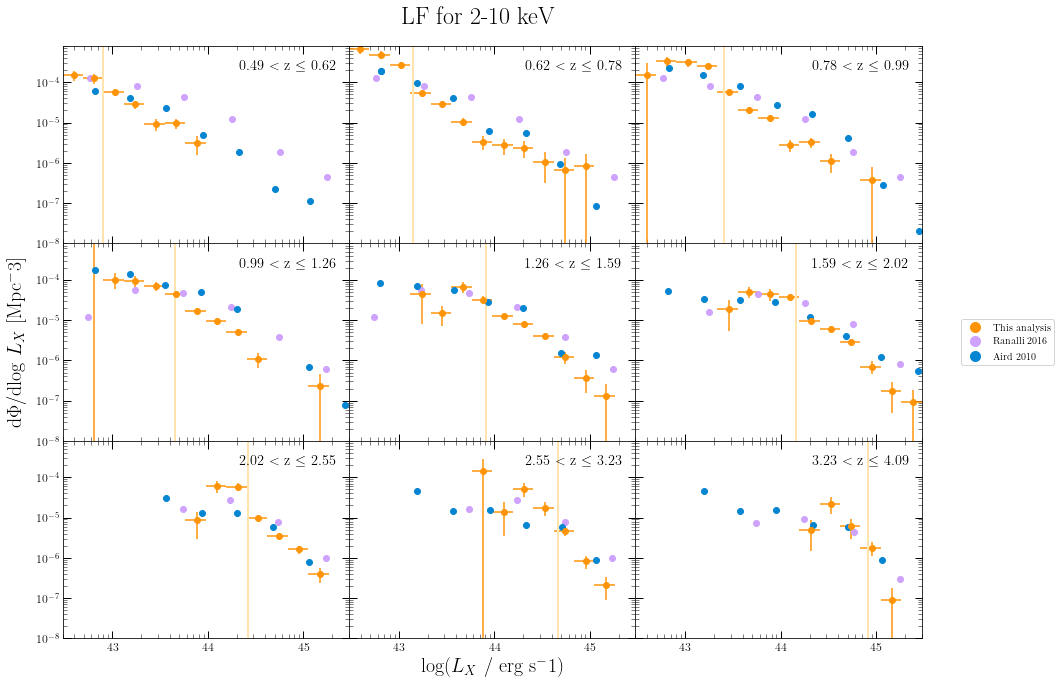

In [12]:

fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, compare_to_others=lit_data, lum_limits=l_limits, title='LF for 2-10 keV', outfile='./xray_lf.png', lum_sublabel='_X')

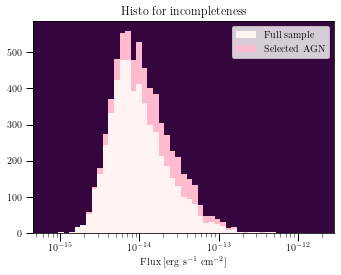

In [13]:
full_fluxes = xservs_catalog['FB_FLUX']
flux_bins = np.logspace(np.log10(min(full_fluxes)), np.log10(max(full_fluxes)), num=50)
fig, ax = vmax.incompleteness_histo(full_fluxes, full_fluxes[good_redshift_and_l_selected], flux_bins=flux_bins)
fig.savefig('./output/incompleteness_histo.png')

In [14]:
from astropy.wcs import WCS

image_file = '/Users/runburg/Downloads/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
hdu = fits.open(image_file)[0]
wcs = WCS(hdu.header)
print(len(fits.open(image_file)))
hdu.header

1


SIMPLE  =                    T / This is a FITS file                            
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 3824 / NUMBER OF ELEMENTS ALONG THIS AXIS             
NAXIS2  =                 2694 / NUMBER OF ELEMENTS ALONG THIS AXIS             
EXTEND  =                    T / This file may contain FITS extensions          
EQUINOX =        2000.00000000 / Mean equinox                                   
MJD-OBS =   5.175600000000E+04 / Modified Julian date at start                  
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   3.550000000000E+01 / World coordinate on this axis                  
CRPIX1  =   1.969000000000E+

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


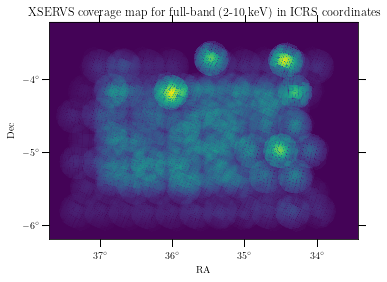

In [15]:
fig = plt.figure()
print(wcs)
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(hdu.data, cmap=plt.cm.viridis)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
lat.set_major_formatter('d')
ax.set_title('XSERVS coverage map for full-band (2-10 keV) in ICRS coordinates')
fig.savefig('./output/exposure_map.png')

In [16]:
dat = hdu.data

In [17]:
np.where(dat < 0)
dat[85, 3051]

-1.1733209

In [18]:

dat[1968], dat[1969]

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [39]:
areas = np.ones(dat.shape)
columns = np.arange(len(areas[0]))

for i in range(len(areas)-1):
    ra1, dec1 = wcs.wcs_pix2world(i, columns, 0)
    ra2, dec2 = wcs.wcs_pix2world(i+1, columns, 0)
    
    length = ra1[1:] - ra1[:-1]
    height = dec2[1:] - dec1[1:]
    
    areas[i, :-1] = length * height
        
areas[-1] = areas[-2]
areas[:, -1] = areas[:, -2]
areas[-1, -1] = areas[-2, -2]
areas[0, 0]
areas[0]
ra1

array([34.69111035, 34.69111167, 34.69111299, ..., 34.69612196,
       34.69612326, 34.69612457])

In [47]:
NAXIS1 = 3824
NAXIS2 = 2694
x = np.arange(NAXIS1)
y = np.arange(NAXIS2)
X, Y = np.meshgrid(x, y)
ra, dec = wcs.wcs_pix2world(X, Y, 0)
areas = (ra[:-1, :-1] - ra[:-1, 1:]) * (dec[1:, :-1] - dec[:-1, :-1])

In [48]:
fluxes = 1/(dat[:-1, :-1]).flatten()
good_indices = ~np.isinf(fluxes)
areas = areas.flatten()[good_indices]
fluxes = fluxes[good_indices]/36
areas

<ipython-input-48-d41c9e4fe9e2>:1: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(dat[:-1, :-1]).flatten()


array([1.23982297e-06, 1.23982145e-06, 1.23981992e-06, ...,
       1.23584902e-06, 1.23584893e-06, 1.23584884e-06])

In [49]:
sort_indices = np.argsort(fluxes)
fluxes = fluxes[sort_indices][1:]
print(fluxes)
print(areas[sort_indices])
areas = np.cumsum(areas[sort_indices][1:])
areas

[-5.6480624e+07 -4.0145572e+07 -1.0310003e+07 ...  6.9971162e+13
  3.9812196e+14  8.0264302e+14]
[1.23703545e-06 1.23712181e-06 1.23842938e-06 ... 1.23963685e-06
 1.23963653e-06 1.23963080e-06]


array([1.23712181e-06, 2.47555119e-06, 3.71243242e-06, ...,
       8.87888027e+00, 8.87888151e+00, 8.87888275e+00])

(0.01, 10)

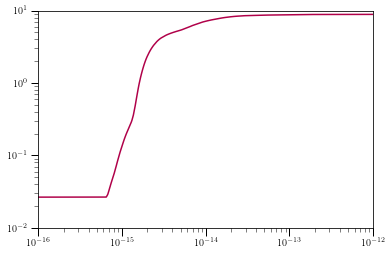

In [55]:
fig, ax = plt.subplots()
ax.plot(fluxes*7e-9, areas, label="this analysis", color='xkcd:raspberry')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(left=1e-16, right=1e-12)
ax.set_ylim(bottom=1e-2, top=10)

In [51]:
ranalli = np.array([[3.234579048402373e-15, 0.046800590726239225],
[3.954492818470057e-15, 0.07962852110271917],
[4.420434711413654e-15, 0.1222991869375129],
[4.856893998989995e-15, 0.18236122222601137],
[5.401461929123689e-15, 0.2908177200919355],
[6.0772268433984334e-15, 0.4357861819497073],
[6.9654850088075764e-15, 0.6424362077190431],
[8.267663307570593e-15, 0.968755801543341],
[1.0366208408568655e-14, 1.4674725828384785],
[1.283839402032368e-14, 2.1666799548490068],
[1.6171488639386294e-14, 2.9727838264231394],
[2.0299866912836456e-14, 3.7432403328810975],
[2.5614185166910568e-14, 4.511438707073378],
[3.171314400418349e-14, 4.953004620220058],
[3.9399813258449504e-14, 5.35993326131349],
[4.965985908263762e-14, 5.5164721661153155],
[6.247029270720968e-14, 5.692346186763688],
[7.756817736170046e-14, 6.049718652378999],
[8.883331632396991e-14, 6.338872460062676
]])

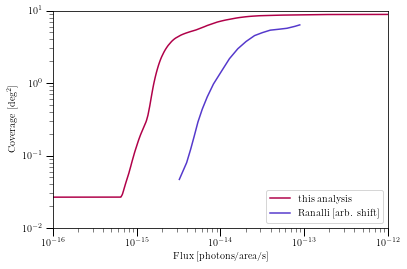

In [56]:
ax.plot(ranalli[:, 0], ranalli[:, 1], label="Ranalli [arb. shift]", color='xkcd:blurple')
ax.legend(loc='lower right')
ax.set_xlabel('Flux [photons/area/s]')
ax.set_ylabel(r'Coverage [deg$^2$]')
fig

In [46]:
fig.savefig('./output/coverage_plot.png')


In [81]:
import scipy.stats

[ 90000.  90001.  90002. ... 299997. 299998. 299999.] [2.25486132e-228 2.50537363e-228 2.78368662e-228 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


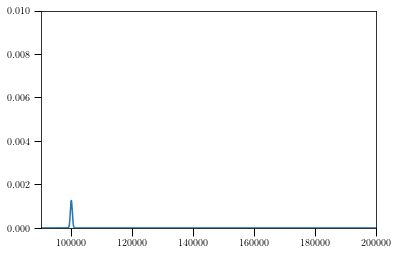

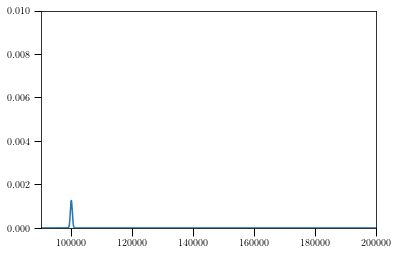

In [103]:
fig, axs = plt.subplots()
vals = np.arange(9e4,3e5)
pdf = scipy.stats.poisson.pmf(vals, 1e5)
print(vals, pdf)
axs.plot(vals, pdf)
axs.set_xlim(left=9e4, right=2e5)
# axs.set_yscale('linear')
axs.set_ylim(bottom=0, top=.01)
fig